In [1]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql('''select 'spark' as hello ''')
df.show()

23/01/01 16:47:59 WARN Utils: Your hostname, mario-hpprobook450g5 resolves to a loopback address: 127.0.1.1; using 141.47.138.10 instead (on interface wlp3s0)
23/01/01 16:47:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/01 16:47:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
+-----+
|hello|
+-----+
|spark|
+-----+



In [2]:
sc = spark.sparkContext

In [3]:
sc.setJobGroup("job group id", "read all input files")
df = spark.read.options(delimiter=";", inferSchema='True', header=True).csv("/home/mario/10minutenwerte_only_100/")
df.printSchema()

root
 |-- STATIONS_ID: double (nullable = true)
 |-- MESS_DATUM: long (nullable = true)
 |-- QN: double (nullable = true)
 |-- PP_10: double (nullable = true)
 |-- TT_10: double (nullable = true)
 |-- TM5_10: double (nullable = true)
 |-- RF_10: double (nullable = true)
 |-- TD_10: double (nullable = true)



In [4]:
sc.setJobGroup("job group id", "show 5 rows of df")
df.show(n=5)

+-----------+------------+---+-----+-----+------+-----+-----+
|STATIONS_ID|  MESS_DATUM| QN|PP_10|TT_10|TM5_10|RF_10|TD_10|
+-----------+------------+---+-----+-----+------+-----+-----+
|     3366.0|199001010000|1.0|972.6| -4.4|  -4.0| 94.0| -4.6|
|     3366.0|199001010010|1.0|972.5| -4.3|  -3.9| 94.0| -4.7|
|     3366.0|199001010020|1.0|972.4| -4.4|  -4.0| 94.0| -4.7|
|     3366.0|199001010030|1.0|972.3| -4.4|  -4.1| 94.0| -4.6|
|     3366.0|199001010040|1.0|972.3| -4.5|  -4.1| 94.0| -4.8|
+-----------+------------+---+-----+-----+------+-----+-----+
only showing top 5 rows



In [5]:
#df.withColumn("MESS_DATUM",df.MESS_DATUM.cast(StringType())) \
#  .show(truncate=False)

In [6]:
from datetime import datetime
from pyspark.sql.functions import col, udf, to_timestamp, year, month
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType, DateType, StringType
sc.setJobGroup("job group id", "select only columns that we need, change column type, rename columns")
df = df.select("STATIONS_ID","MESS_DATUM","TT_10")
df = df.withColumn("MESS_DATUM",col("MESS_DATUM").cast(StringType()))
df = df.withColumn("STATIONS_ID",col("STATIONS_ID").cast(IntegerType()))
df = df.withColumn("MESS_DATUM",to_timestamp("MESS_DATUM", "yyyyMMddHHmm"))

In [7]:
sc.setJobGroup("job group id", "print schema")
df.printSchema()

root
 |-- STATIONS_ID: integer (nullable = true)
 |-- MESS_DATUM: timestamp (nullable = true)
 |-- TT_10: double (nullable = true)



In [8]:
sc.setJobGroup("job group id", "show 5 rows of df")
df.show(n=5)

+-----------+-------------------+-----+
|STATIONS_ID|         MESS_DATUM|TT_10|
+-----------+-------------------+-----+
|       3366|1990-01-01 00:00:00| -4.4|
|       3366|1990-01-01 00:10:00| -4.3|
|       3366|1990-01-01 00:20:00| -4.4|
|       3366|1990-01-01 00:30:00| -4.4|
|       3366|1990-01-01 00:40:00| -4.5|
+-----------+-------------------+-----+
only showing top 5 rows



Bauernregel:

„Wenn's im Dezember nicht wintert, sommert's im Juni auch nicht.“

Hierbei handelt es sich im Prinzip um die entgegengesetzte Regel zu der vorherigen:
Im Juni wird es nicht warm, wenn im Dezember kein richtiger Winter war.
Es stimmt, dass die These zu 65 Prozent eintrifft. Andersrum, wenn es also im Juni nicht „sommert“, wird es im Dezember nicht „wintern“,
stimmt die Bauernregel aber nicht. Warum das so ist, weiß keiner so genau.


In [9]:
from pyspark.sql import functions as F
sc.setJobGroup("job group id", "group by")
df.groupBy("STATIONS_ID").agg(F.min("MESS_DATUM"), F.max("MESS_DATUM")).show(n=500)

+-----------+-------------------+-------------------+
|STATIONS_ID|    min(MESS_DATUM)|    max(MESS_DATUM)|
+-----------+-------------------+-------------------+
|       3287|1991-01-01 01:00:00|1999-12-31 23:50:00|
|       3023|1991-01-01 01:00:00|1999-12-31 23:50:00|
|       3366|1990-01-01 00:00:00|1999-12-31 23:50:00|
|       1468|1991-01-01 01:00:00|1999-12-31 23:50:00|
|       1550|1991-01-01 01:00:00|1999-12-31 23:50:00|
|        348|1991-01-01 01:00:00|1999-12-31 23:50:00|
|        691|1991-06-19 15:00:00|1999-12-31 23:50:00|
|       2044|1991-01-14 11:00:00|1999-12-31 23:50:00|
|       4466|1991-04-17 14:00:00|1999-12-31 23:50:00|
|       5397|1991-07-04 10:00:00|1999-12-31 23:50:00|
|        591|1991-10-31 14:00:00|1999-12-31 23:50:00|
|       1957|1991-10-31 20:00:00|1999-12-31 23:50:00|
|       3126|1991-11-01 00:00:00|1999-12-31 23:50:00|
|       1544|1991-11-01 00:00:00|1999-12-31 23:50:00|
|        656|1991-08-08 03:00:00|1999-12-31 23:50:00|
|        164|1991-10-31 23:0

In [10]:
#df.describe().show()


In [11]:
# we only need months June and Decemeber
sc.setJobGroup("job group id", "filter only june and december")
df = df.filter((month("MESS_DATUM") == 6) | (month("MESS_DATUM") == 12))
df.show()

+-----------+-------------------+-----+
|STATIONS_ID|         MESS_DATUM|TT_10|
+-----------+-------------------+-----+
|       3366|1990-06-01 00:00:00|  6.7|
|       3366|1990-06-01 00:10:00|  6.9|
|       3366|1990-06-01 00:20:00|  6.2|
|       3366|1990-06-01 00:30:00|  5.8|
|       3366|1990-06-01 00:40:00|  5.8|
|       3366|1990-06-01 00:50:00|  6.0|
|       3366|1990-06-01 01:00:00|  6.1|
|       3366|1990-06-01 01:10:00|  6.0|
|       3366|1990-06-01 01:20:00|  5.9|
|       3366|1990-06-01 01:30:00|  5.6|
|       3366|1990-06-01 01:40:00|  5.7|
|       3366|1990-06-01 01:50:00|  6.3|
|       3366|1990-06-01 02:00:00|  6.5|
|       3366|1990-06-01 02:10:00|  6.8|
|       3366|1990-06-01 02:20:00|  5.8|
|       3366|1990-06-01 02:30:00|  5.3|
|       3366|1990-06-01 02:40:00|  5.5|
|       3366|1990-06-01 02:50:00|  5.5|
|       3366|1990-06-01 03:00:00|  6.5|
|       3366|1990-06-01 03:10:00|  7.3|
+-----------+-------------------+-----+
only showing top 20 rows



In [12]:
sc.setJobGroup("job group id", "convert timestamp into month and year")
df = df.select("STATIONS_ID", year("MESS_DATUM").alias("year"),month("MESS_DATUM").alias("month"), "TT_10")
df.show()

+-----------+----+-----+-----+
|STATIONS_ID|year|month|TT_10|
+-----------+----+-----+-----+
|       3366|1990|    6|  6.7|
|       3366|1990|    6|  6.9|
|       3366|1990|    6|  6.2|
|       3366|1990|    6|  5.8|
|       3366|1990|    6|  5.8|
|       3366|1990|    6|  6.0|
|       3366|1990|    6|  6.1|
|       3366|1990|    6|  6.0|
|       3366|1990|    6|  5.9|
|       3366|1990|    6|  5.6|
|       3366|1990|    6|  5.7|
|       3366|1990|    6|  6.3|
|       3366|1990|    6|  6.5|
|       3366|1990|    6|  6.8|
|       3366|1990|    6|  5.8|
|       3366|1990|    6|  5.3|
|       3366|1990|    6|  5.5|
|       3366|1990|    6|  5.5|
|       3366|1990|    6|  6.5|
|       3366|1990|    6|  7.3|
+-----------+----+-----+-----+
only showing top 20 rows



In [13]:
# remove missing values
sc.setJobGroup("job group id", "remove missing values")
df = df.filter((df.TT_10 != -999.0))

In [14]:
# calculate average temperature for each year+month+stations_id
sc.setJobGroup("job group id", "calculate average temperature for each year+month+stations_id")
df = df.groupBy("year", "month", "STATIONS_ID").avg("TT_10")
df.show()

+----+-----+-----------+-------------------+
|year|month|STATIONS_ID|         avg(TT_10)|
+----+-----+-----------+-------------------+
|1998|   12|       3366|-1.1544822949350064|
|1997|    6|       3366|  16.27305555555556|
|1998|   12|       3287| 0.6422981785473398|
|1999|    6|       3366| 15.699606481481515|
|1997|   12|       3366| 0.8322356630824369|
|1999|    6|       3287| 14.825902777777793|
|1997|   12|       3287|  1.393297466935662|
|1993|   12|       3287| 2.6650765076507605|
|1996|    6|       3023|  15.60687659180368|
|1995|    6|       3023|   14.8692289881917|
|1991|    6|       3023| 12.904959443800692|
|1995|    6|       3287| 13.723310185185213|
|1997|   12|       3023|  4.056115591397865|
|1998|    6|       3366|  17.09474912485418|
|1994|    6|       3366|  16.76222737819026|
|1991|    6|       3366| 14.654583333333356|
|1999|   12|       3023|  4.099731062303909|
|1997|    6|       3287| 14.595046296296315|
|1990|   12|       3366| -1.782831181252991|
|1999|    

In [15]:
sc.setJobGroup("job group id", "new dataframe with only december")
df2 = df.filter(df.month == 12)
df2.show()

+----+-----+-----------+--------------------+
|year|month|STATIONS_ID|          avg(TT_10)|
+----+-----+-----------+--------------------+
|1998|   12|       3366| -1.1544822949350064|
|1998|   12|       3287|  0.6422981785473398|
|1997|   12|       3366|  0.8322356630824369|
|1997|   12|       3287|   1.393297466935662|
|1993|   12|       3287|  2.6650765076507605|
|1997|   12|       3023|   4.056115591397865|
|1999|   12|       3023|   4.099731062303909|
|1990|   12|       3366|  -1.782831181252991|
|1993|   12|       3023|   4.374932795698943|
|1991|   12|       3287|-0.45028885037550465|
|1993|   12|       3366|  2.4830121021963185|
|1995|   12|       3366| -1.2314964157706085|
|1996|   12|       3023| -1.2555583501006038|
|1994|   12|       3287|   3.125325550067363|
|1996|   12|       3366|  -4.925990752972258|
|1999|   12|       3366|-0.18109441578829447|
|1995|   12|       3023|  -1.468154294684908|
|1994|   12|       3023|   4.909027777777788|
|1994|   12|       3366|    2.0228

In [16]:
from pyspark.sql.functions import lit

sc.setJobGroup("job group id", "adding additional month and year columns")
df2 = df2.withColumnRenamed('avg(TT_10)', 'temperature_december')
df2 = df2.withColumnRenamed('year', 'year_december')
df2 = df2.withColumnRenamed('month', 'month_december')
df2 = df2.withColumn('year_june', df2.year_december + 1)
df2 = df2.withColumn('month_june', lit(6))
df2.show()

+-------------+--------------+-----------+--------------------+---------+----------+
|year_december|month_december|STATIONS_ID|temperature_december|year_june|month_june|
+-------------+--------------+-----------+--------------------+---------+----------+
|         1998|            12|       3366| -1.1544822949350064|     1999|         6|
|         1998|            12|       3287|  0.6422981785473398|     1999|         6|
|         1997|            12|       3366|  0.8322356630824369|     1998|         6|
|         1997|            12|       3287|   1.393297466935662|     1998|         6|
|         1993|            12|       3287|  2.6650765076507605|     1994|         6|
|         1997|            12|       3023|   4.056115591397865|     1998|         6|
|         1999|            12|       3023|   4.099731062303909|     2000|         6|
|         1990|            12|       3366|  -1.782831181252991|     1991|         6|
|         1993|            12|       3023|   4.374932795698943|  

In [17]:
sc.setJobGroup("job group id", "join two dataframes")
df2 = df2.join(df, (df2.year_june == df.year) & (df2.month_june == df.month) & (df2.STATIONS_ID == df.STATIONS_ID)).select(df2["*"], df["avg(TT_10)"])
df2 = df2.withColumnRenamed('avg(TT_10)', 'temperature_june')
df2.show()

+-------------+--------------+-----------+--------------------+---------+----------+------------------+
|year_december|month_december|STATIONS_ID|temperature_december|year_june|month_june|  temperature_june|
+-------------+--------------+-----------+--------------------+---------+----------+------------------+
|         1996|            12|       3366|  -4.925990752972258|     1997|         6| 16.27305555555556|
|         1998|            12|       3366| -1.1544822949350064|     1999|         6|15.699606481481515|
|         1998|            12|       3287|  0.6422981785473398|     1999|         6|14.825902777777793|
|         1995|            12|       3023|  -1.468154294684908|     1996|         6| 15.60687659180368|
|         1994|            12|       3023|   4.909027777777788|     1995|         6|  14.8692289881917|
|         1994|            12|       3287|   3.125325550067363|     1995|         6|13.723310185185213|
|         1997|            12|       3366|  0.8322356630824369| 

In [18]:
sc.setJobGroup("job group id", "calculate correlation")
df2.corr("temperature_december", "temperature_june", method="pearson")

0.24578055812887734

In [19]:
#df2.coalesce(1).write.mode("overwrite").option("header", "true").csv("/hdfs://192.168.199.80:9000/user/mario/output_files/10minutenwerte_only_100_result")

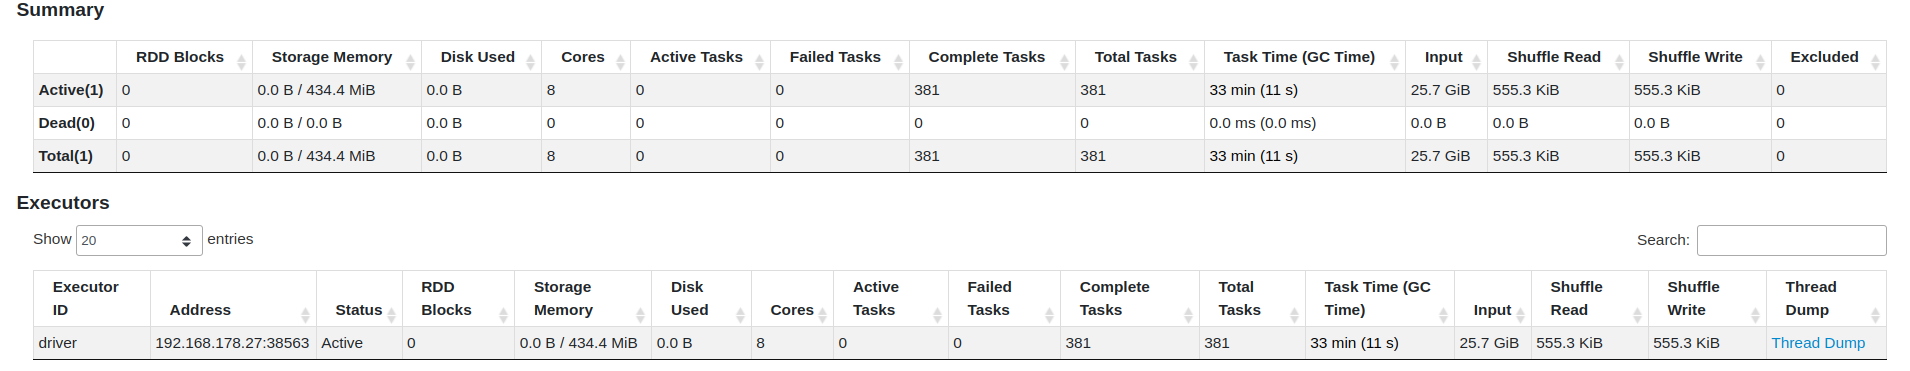